In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [7]:
df.Age.fillna(df.Age.mean(), inplace=True)
df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)

In [8]:
df.drop_duplicates
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.699118,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


In [9]:
le = LabelEncoder()

for col in ['Sex', 'Embarked']:
  if df[col].dtype == 'object':
    df[col] = le.fit_transform(df[col].astype(str))

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [10]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [11]:
df_majority = df[df.Survived==0]
df_minority = df[df.Survived==1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)

df = pd.concat([df_majority, df_minority_upsampled])
df.Survived.value_counts()

Survived
0    549
1    549
Name: count, dtype: int64

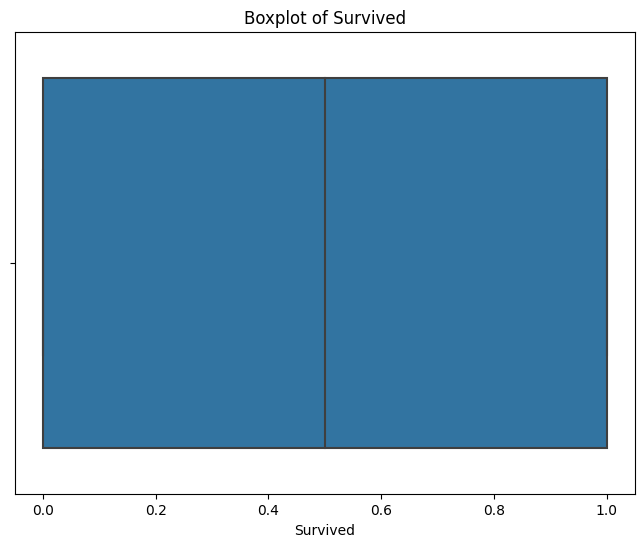

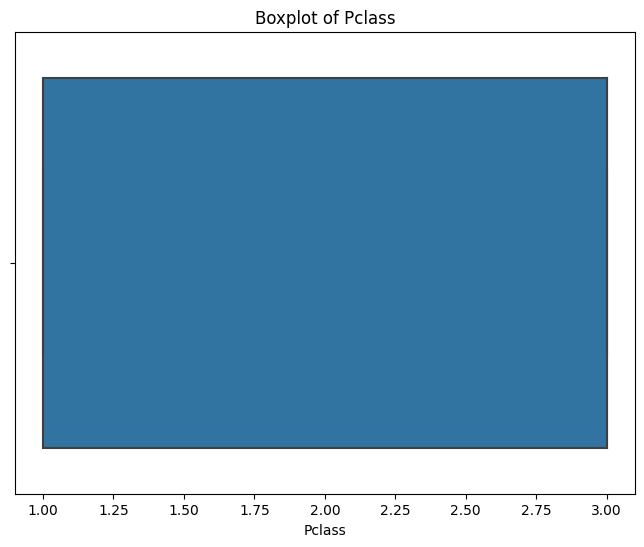

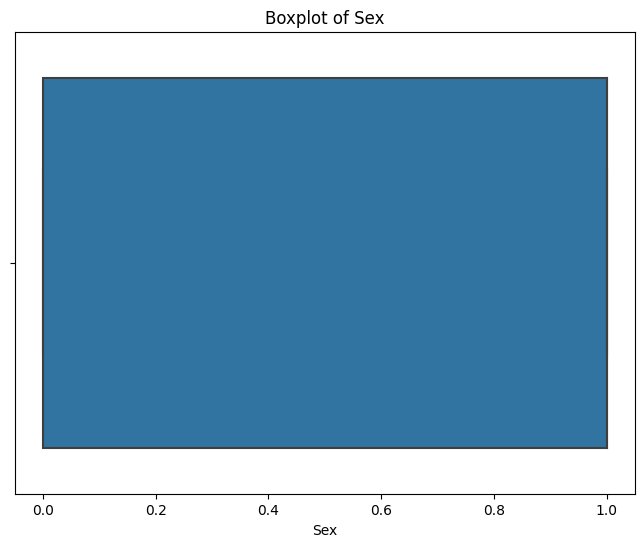

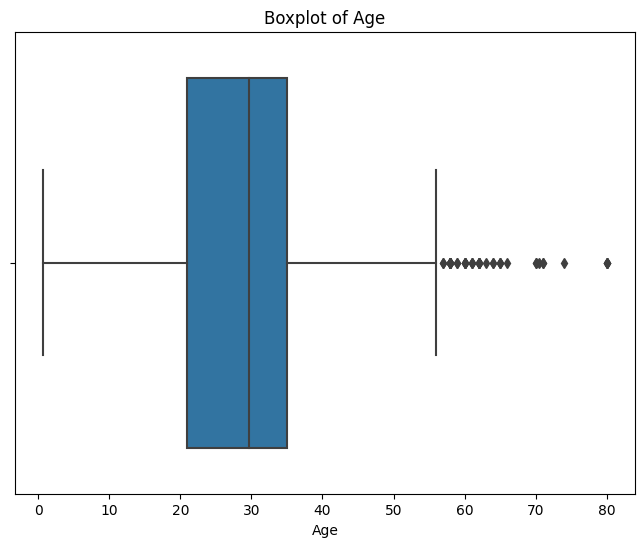

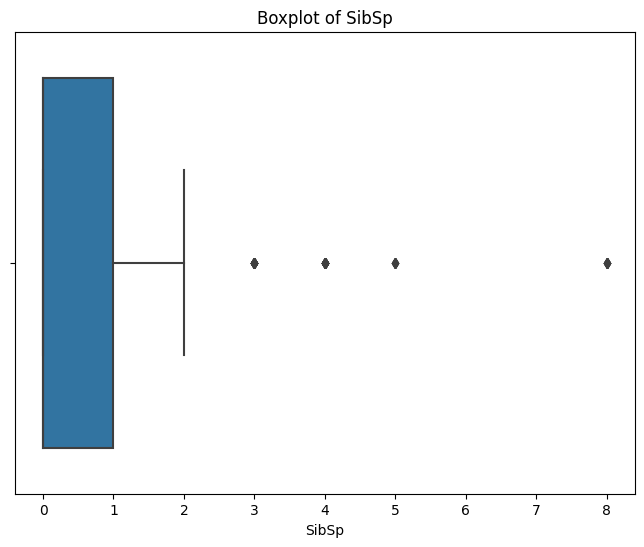

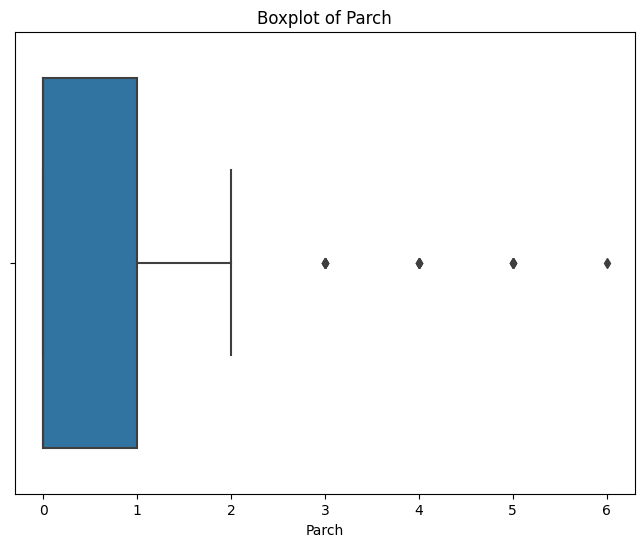

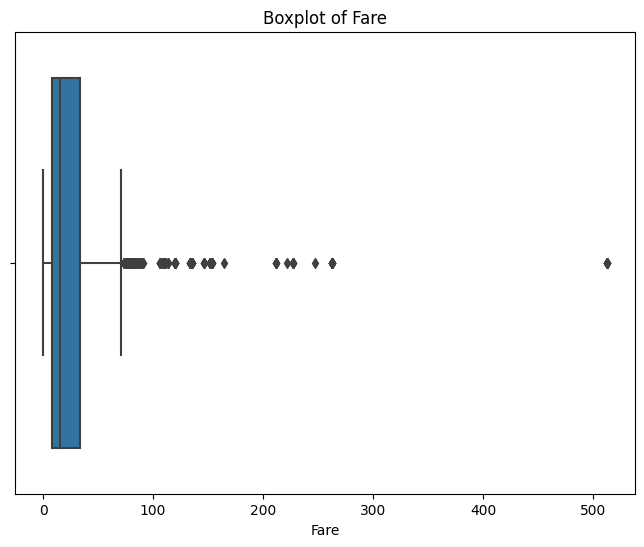

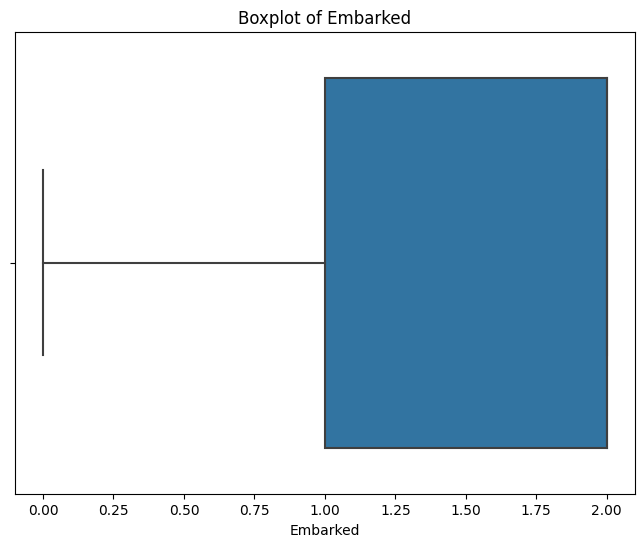

In [12]:
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


In [13]:
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Age'] >= lower_bound) & (df['Age'] <= upper_bound)]
df = df.drop(df[df.Fare > 250].index)

df.shape

(1040, 8)

In [14]:
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
#random forest tree

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

print(classification_report(y_test, y_pred_rf))

mse_rf = mean_squared_error(y_test, y_pred_rf)

rmse_rf = np.sqrt(mse_rf)

error_percentage_rf = (rmse_rf / np.mean(y_test)) * 100

print(f"Random Forest Error Percentage: {error_percentage_rf:.2f}%")


Random Forest Accuracy: 0.8884615384615384
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       127
           1       0.89      0.89      0.89       133

    accuracy                           0.89       260
   macro avg       0.89      0.89      0.89       260
weighted avg       0.89      0.89      0.89       260

Random Forest Error Percentage: 65.29%


In [16]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f'Best Random Forest Accuracy: {accuracy_best_rf}')



Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.87
Best Random Forest Accuracy: 0.8846153846153846


In [17]:
# df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
# passenger_ids = df_test['PassengerId']
# df_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
# df_test.Age.fillna(df_test.Age.mean(), inplace=True)
# df_test.Embarked.fillna(df_test.Embarked.mode()[0], inplace=True)

# for col in ['Sex', 'Embarked']:
#   if df_test[col].dtype == 'object':
#     df_test[col] = le.fit_transform(df_test[col].astype(str))


# y_pred_test = best_rf_model.predict(df_test)

# submission_df = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': y_pred_test})
# submission_df.to_csv('submission.csv', index=False)
